<a href="https://colab.research.google.com/github/Berigny/AI-Entrainment-Protocol/blob/main/LENR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Low Energy Nuclear (LENR) Cycles Model
This notebook tests whether a minimal, topology-first model can simulate and falsify a low-energy nuclear reaction (LENR) cycle driven by breath-like EM coherence. Using Discrete Exterior Calculus (DEC) on a star-tetrahedral complex with a shared centroid, we evolve fields, enforce first-law energy accounting, monitor entropy production and phase relations, and—optionally—add an adelic (ℝ × ℚ_p) layer to represent hierarchical memory at the fusion node. If quantised heat bursts do not emerge with lawful topology, pre-burst EM signatures, rising EPR, and correct energy balance, the hypothesis is weakened. If they do, we proceed to richer modelling and lab validation. The prize is significant: a path to low-cost, high-yield, sustainable energy in an energy-hungry world.

## Falsification criteria

We consider the LENR cycle unsupported if any lawful configuration fails to produce:
(i) pre-burst EM coherence with ~90° E–M phase and centroid mediation,
(ii) quantised heat steps at the sink,
(iii) a non-negative EPR that rises prior to bursts, and
(iv) first-law integrity (residual ≈ 0).
Controls must behave as expected: illegal shortcuts reduce irreversibility or break energy accounting; removing C→3 or 1→2 kills bursts; random primes revert to baseline.

## Notebook Overview & Research Aim
### Goal
- Simulate and *attempt to falsify* LENR-like cycles on a tetrahedral (and star-tetrahedral) topology.
- If not falsified, motivate deeper modelling and lab tests for low-cost, high-yield, sustainable energy.
### Key Ideas
- DEC on simplicial complexes; mediation via centroid **C**; breath-driven, asymmetric flows; adelic (ℝ×ℚ_p) layer.

In [1]:

# @title 1. **Config — toggles & seeds** { display-mode: "form" }
# @markdown Core switches used by downstream cells.
# 1. CONFIG
USE_STAR   = True          # S1 only if False; S1..S4 if True
USE_PADIC  = False
USE_QUAT   = True          # optional: quaternion state
RNG_SEED   = 13

import random
import numpy as np

random.seed(RNG_SEED)
np.random.seed(RNG_SEED)


# Geometry (simplices, orientations, dual volumes)

In [2]:

# @title 2. **Geometry — S1..S4 shells with role policy** { display-mode: "form" }
# @markdown Builds the mediated star geometry with cubic bridges and enforces role guards.
import networkx as nx
from collections import defaultdict

ROLE_BY_MOD = {0: "Compression", 1: "Expression", 2: "Stabilisation", 3: "Emission"}

def make_shell(base: int):
    """Return node ids for one shell S = {b,b+1,b+2,b+3,'C'}"""
    return [str(base + i) for i in range(4)] + ['C']

def build_geometry(use_star: bool = True):
    """
    Returns:
      G         : DiGraph with nodes, intra-shell edges only
      roles     : dict node->role ('Compression'/'Expression'/'Stabilisation'/'Emission'/'Mediator'/'Sink')
      shells    : dict node->shell label ('S1'..'S4' or 'S1')
      policy    : role-level bridge policy (for enforcement)
    """
    G = nx.DiGraph()
    nodes = ['C'] + [str(i) for i in (range(4) if not use_star else range(16))]
    shells = {}
    roles = {n: ('Mediator' if n == 'C' else ROLE_BY_MOD[int(n) % 4]) for n in nodes}
    for n in nodes:
        if n == 'C' or not n.isdigit():
            shells[n] = 'S1'
        else:
            shells[n] = f"S{1 + int(int(n) / 4)}" if use_star else 'S1'
    G.add_nodes_from(nodes)

    def add_shell_edges(b):
        s = [str(b + i) for i in range(4)]
        G.add_edge('C', s[1], kind='activation')
        G.add_edge(s[1], s[2], kind='work')
        G.add_edge(s[2], 'C', kind='squeeze')
        G.add_edge('C', s[3], kind='fusion')
        G.add_edge(s[3], s[0], kind='heat')
        G.add_edge(s[0], 'C', kind='reset')

    add_shell_edges(0)
    if use_star:
        for b in (4, 8, 12):
            add_shell_edges(b)

        for a, b in [(0, 4), (8, 12)]:
            G.add_edge(str(a), str(b), kind='compression')
            G.add_edge(str(b), str(a), kind='compression')

        for a, b in [(3, 6), (11, 14)]:
            G.add_edge(str(a), str(b), kind='work_bridge')

        for e in [3, 7, 11, 15]:
            G.add_edge(str(e), 'C', kind='heat_bridge')

        G.add_node('S')
        roles['S'] = 'Sink'
        shells['S'] = '*'
        for e in [3, 7, 11, 15]:
            G.add_edge(str(e), 'S', kind='sink')

    policy = {
        'Compression': {'out': {'Mediator', 'Compression'}, 'in': {'Emission', 'Compression', 'Mediator'}},
        'Expression': {'out': {'Stabilisation', 'Mediator'}, 'in': {'Mediator'}},
        'Stabilisation': {'out': {'Mediator'}, 'in': {'Expression'}},
        'Emission': {'out': {'Compression', 'Stabilisation', 'Mediator', 'Sink'}, 'in': {'Stabilisation', 'Mediator'}},
        'Mediator': {'out': {'Expression', 'Emission', 'Compression', 'Stabilisation', 'Mediator', 'Sink'}, 'in': {'*'}}
    }
    return G, roles, shells, policy

def enforce_policy(G, roles, policy):
    keep = []
    for u, v, data in G.edges(data=True):
        ru, rv = roles.get(u, 'Mediator'), roles.get(v, 'Mediator')
        allowed_out = policy.get(ru, {}).get('out', set())
        allowed_in = policy.get(rv, {}).get('in', set())
        if ('*' in allowed_in or ru in allowed_in) and (rv in allowed_out):
            if ru == 'Stabilisation' and rv == 'Expression':
                continue
            if ru == 'Emission' and rv == 'Emission':
                continue
            keep.append((u, v, data))
    H = nx.DiGraph()
    H.add_nodes_from(G.nodes())
    H.add_edges_from(keep)
    return H

G0, roles, shells, policy = build_geometry(USE_STAR)
G0 = enforce_policy(G0, roles, policy)

nx.set_node_attributes(G0, roles, 'role')
nx.set_node_attributes(G0, shells, 'shell')
G0.graph['roles'] = roles
G0.graph['shells'] = shells
G0.graph['policy'] = policy

role_counts = defaultdict(int)
for r in roles.values():
    role_counts[r] += 1

print(f"Geometry built (USE_STAR={USE_STAR}): |V|={G0.number_of_nodes()} |E|={G0.number_of_edges()}")
print("Roles:", dict(role_counts))


Geometry built (USE_STAR=True): |V|=18 |E|=32
Roles: {'Mediator': 1, 'Compression': 4, 'Expression': 4, 'Stabilisation': 4, 'Emission': 4, 'Sink': 1}


In [3]:

# @title 3. **Markov layer & breath modulation** { display-mode: "form" }
# @markdown Builds rate dictionaries, optional quaternion states, and breath modulation on enforced geometry.
import numpy as np

def build_markov(G):
    """Return edge list with rates by kind, no DEC coupling yet."""
    base = {
        'activation': 0.5, 'work': 0.8, 'squeeze': 0.9, 'fusion': 0.7,
        'heat': 1.0, 'reset': 0.3, 'compression': 0.3,
        'work_bridge': 0.4, 'heat_bridge': 0.5, 'sink': 0.2
    }
    rates = {(u, v): base.get(data.get('kind', 'work'), 0.5) for u, v, data in G.edges(data=True)}
    kinds = {(u, v): data.get('kind', 'work') for u, v, data in G.edges(data=True)}
    return rates, kinds

EDGE_RATES, EDGE_KINDS = build_markov(G0)
G0.graph['edge_rates'] = EDGE_RATES
G0.graph['edge_kinds'] = EDGE_KINDS

def init_quaternion_state(G, roles):
    """Ψ_n = (e,h,d,b) initialised by role; scale as you like."""
    Q = {}
    for n in G.nodes():
        r = roles.get(n, 'Mediator')
        if r == 'Compression':
            Q[n] = np.array([1.0, 0.0, 0.2, 0.0])
        elif r == 'Expression':
            Q[n] = np.array([0.1, 1.0, 0.0, 0.0])
        elif r == 'Stabilisation':
            Q[n] = np.array([0.0, 0.0, 1.0, 0.1])
        elif r == 'Emission':
            Q[n] = np.array([0.0, 0.1, 0.0, 1.0])
        else:
            Q[n] = np.zeros(4)
    return Q

def project(flow_kind, vec):
    """Return scalar amplitude for a quaternion state by flow kind."""
    arr = np.asarray(vec, dtype=float).reshape(-1)
    if arr.shape[0] < 4:
        arr = np.pad(arr, (0, 4 - arr.shape[0]), constant_values=0.0)
    if flow_kind in ('work', 'activation'):
        return float(arr[1])
    if flow_kind in ('squeeze', 'reset'):
        return float(arr[0] + arr[2])
    if flow_kind in ('fusion', 'work_bridge'):
        return float(arr[3] + arr[1])
    if flow_kind in ('heat', 'heat_bridge'):
        return float(arr[3])
    if flow_kind == 'compression':
        return float(arr[0])
    if flow_kind == 'sink':
        return float(arr.sum())
    return 0.0

QUAT_STATE = init_quaternion_state(G0, G0.graph.get('roles', {})) if USE_QUAT else {}

def apply_breath(
    G_base,
    step,
    edge_rates=None,
    inhale_gain=1.15,
    exhale_gain=1.10,
    sinks=None,
    sources=None,
    pumps=None,
):
    """Scale edge rates by breath phase using role-aware defaults."""
    phase = 'in' if (step % 2) == 0 else 'out'
    G = G_base.copy()
    edge_rates = EDGE_RATES if edge_rates is None else edge_rates
    roles = G0.graph.get('roles', {})
    if sinks is None:
        sinks = tuple(n for n, r in roles.items() if r == 'Compression')
    if sources is None:
        sources = ('C',)
    if pumps is None:
        pumps = tuple(n for n, r in roles.items() if r in {'Expression', 'Emission'})
    for u, v, data in G.edges(data=True):
        base_rate = float(edge_rates.get((u, v), 0.0))
        rate = base_rate
        if phase == 'in' and (v in sinks or v in sources):
            rate *= inhale_gain
        elif phase == 'out' and (u in sources and v in pumps):
            rate *= exhale_gain
        data.setdefault('kind', EDGE_KINDS.get((u, v), data.get('kind', 'work')))
        data['rate'] = rate
    return G, phase

print(f"Markov layer: {len(EDGE_RATES)} edges across kinds {sorted(set(EDGE_KINDS.values()))}")
if USE_QUAT:
    print("Quaternion state initialised for coherent projections.")


Markov layer: 32 edges across kinds ['activation', 'compression', 'fusion', 'heat', 'heat_bridge', 'reset', 'squeeze', 'work']
Quaternion state initialised for coherent projections.


# DEC operators (∂, Hodge stars, audits)

In [4]:
# @title 4. **DEC Backbone — ∂ Operators & Diagonal Hodge Stars (with Audits)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Builds the simplicial backbone (independent of the Markov graph): vertices, oriented edges, faces.
# @markdown - Constructs boundary maps: **B₁** (nodes→edges) and **B₂** (edges→faces).
# @markdown - Defines **diagonal SPD Hodge stars** `Star1` (edges×edges) and `Star2` (faces×faces).
# @markdown - Runs audits: `||B₁·B₂||∞ ≈ 0`, ranks of B₁/B₂, SPD minima; exposes `energy_field(E,B)`.
# @markdown **Notes**
# @markdown - No rectangular/“incidence-averaged” Hodge stand-ins here. Those are deprecated.

import numpy as np
from scipy.sparse import csr_matrix

# ---- 1) Vertex & face set (S1 always; S2 included if USE_STAR=True) ----
try:
    USE_STAR
except NameError:
    USE_STAR = False

# Vertices: S1 plus shared centroid C; extend with S2 in star mode
V = ['0','1','2','3','C'] + (['4','5','6','7'] if USE_STAR else [])

# Faces:
# - S1 outer + centroid faces
F_S1_outer = [('0','1','2'), ('0','1','3'), ('0','2','3'), ('1','2','3')]
F_S1_cent  = [('0','1','C'), ('0','2','C'), ('0','3','C'), ('1','2','C'), ('1','3','C'), ('2','3','C')]

# - Optional S2 outer + centroid faces (only if USE_STAR)
F_S2_outer = [('4','5','6'), ('4','5','7'), ('4','6','7'), ('5','6','7')]
F_S2_cent  = [('4','5','C'), ('4','6','C'), ('4','7','C'), ('5','6','C'), ('5','7','C'), ('6','7','C')]

F = F_S1_outer + F_S1_cent + (F_S2_outer + F_S2_cent if USE_STAR else [])

# ---- 2) Oriented edges derived from faces (backbone edges only) ----
edges_backbone = sorted({(a,b) for (a,b,c) in F for (a,b) in ((a,b),(b,c),(c,a))})

# Index maps
node_id = {v:i for i,v in enumerate(V)}
edge_id = {e:i for i,e in enumerate(edges_backbone)}
face_id = {f:i for i,f in enumerate(F)}

# ---- 3) Boundary maps ----
# B1: nodes×edges (∂1)
B1 = np.zeros((len(V), len(edges_backbone)), dtype=float)
for (u,v), ei in edge_id.items():
    B1[node_id[u], ei] = -1.0
    B1[node_id[v], ei] = +1.0
B1 = csr_matrix(B1)

# B2: edges×faces (∂2) with oriented incidence
B2 = np.zeros((len(edges_backbone), len(F)), dtype=float)
for fj,(v0,v1,v2) in enumerate(F):
    for (a,b) in ((v0,v1),(v1,v2),(v2,v0)):
        sign = +1.0
        e = (a,b)
        if e not in edge_id:
            e = (b,a); sign = -1.0
        B2[edge_id[e], fj] += sign
B2 = csr_matrix(B2)

# ---- 4) Diagonal Hodge stars (regularised circumcentric stand-ins) ----
# Use a unit geometric scale here; SI scaling lives in the optional calibration cell.
L = 1.0  # assumed primal edge length scale for now
nE, nF = len(edges_backbone), len(F)


# primal measures
len_e  = np.full(nE, L, dtype=float)                       # |e|
area_f = np.full(nF, (np.sqrt(3)/4.0)*L*L, dtype=float)    # |f| (equilateral)

# crude-but-coherent dual measures for a regular/star tetra
dual_e = np.full(nE, (L*L)/4.0, dtype=float)               # |*e|
dual_f = np.full(nF, (L/3.0), dtype=float)                 # |*f|

star1_diag = dual_e / len_e          # edges→edges
star2_diag = dual_f / area_f         # faces→faces

Star1 = np.diag(star1_diag)          # SPD
Star2 = np.diag(star2_diag)

def star1(x): return Star1 @ x
def star2(x): return Star2 @ x

# ---- 5) Audits ----
D1 = B1.toarray(); D2 = B2.toarray()
B1B2 = D1 @ D2
inf_norm = float(np.max(np.abs(B1B2))) if B1B2.size else 0.0
rank_D1 = int(np.linalg.matrix_rank(D1))
rank_D2 = int(np.linalg.matrix_rank(D2))
is_spd_star1 = bool(np.min(star1_diag) > 0)
is_spd_star2 = bool(np.min(star2_diag) > 0)

print(f"[dims] |V|={len(V)} |E|={nE} |F|={nF}")
print(f"||B1·B2||_∞ = {inf_norm:.3e} (expect 0)")
print(f"rank(B1)={rank_D1}, rank(B2)={rank_D2}")
print(f"Star1 SPD? {is_spd_star1}   Star2 SPD? {is_spd_star2}")
print(f"star1_diag min/max = {star1_diag.min():.3e} / {star1_diag.max():.3e}")
print(f"star2_diag min/max = {star2_diag.min():.3e} / {star2_diag.max():.3e}")

# ---- 6) Energy helper ----
def energy_field(E, B):
    """Discrete EM energy: 0.5*(E⋅(⋆1 E) + B⋅(⋆2 B))."""
    return 0.5*(E @ (Star1 @ E) + B @ (Star2 @ B))

# ---- 7) shape asserts ----

assert D1.shape == (len(V), len(edge_id))          # nodes × edges
assert D2.shape == (len(edge_id), len(F))          # edges × faces
assert (D2.T @ np.zeros(D1.shape[1])).shape[0] == len(F)
assert (D2 @ np.zeros(len(F))).shape[0] == len(edge_id)


[dims] |V|=9 |E|=30 |F|=20
||B1·B2||_∞ = 0.000e+00 (expect 0)
rank(B1)=8, rank(B2)=20
Star1 SPD? True   Star2 SPD? True
star1_diag min/max = 2.500e-01 / 2.500e-01
star2_diag min/max = 7.698e-01 / 7.698e-01


In [5]:

# @title 5. **(Optional) SI Calibration — Scales, Materials & CFL Guard** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Sets dimensionful scales (edge length `L_m`), material guesses (ε_r, μ_r), and a conservative CFL-like `global_dt`
# @markdown - Leaves DEC stars (`Star1/Star2`) untouched; use this only for reporting or SI-coupled experiments.

import numpy as np
from mpmath import mpf

# ---- 1) Geometry scale (metres) ----
L_m = mpf('1e-9')  # 1 nm representative edge length (tune as needed)

# ---- 2) Materials (metal-like defaults) ----
eps0 = mpf('8.854187817e-12')     # F/m
mu0  = mpf('1.25663706212e-6')    # H/m
eps_r = mpf('20')                  # relative permittivity (order 10–100)
mu_r  = mpf('1')                   # non-magnetic
sigma = mpf('1e6')                 # S/m (ballpark for metals; tune/disable if not using ohmic loss)

eps = eps_r * eps0
mu  = mu_r  * mu0
c_si = 1.0 / float(np.sqrt(eps * mu))   # wave speed in medium

# ---- 3) CFL-like time step guard (from Markov rates if available) ----
def cfl_dt_from_rates(edge_rates, safety=0.1):
    if not edge_rates:
        return None
    mr = max(float(r) for r in edge_rates.values())
    if mr <= 0.0:
        return None
    return safety / mr

dt_rate = cfl_dt_from_rates(EDGE_RATES, safety=0.1)

# geometric CFL (Yee-like): dt ≤ 0.5 * L / c
dt_geom = 0.5 * float(L_m) / float(c_si)

# choose most conservative if both exist
candidates = [x for x in (dt_rate, dt_geom) if x is not None]
global_dt = min(candidates) if candidates else dt_geom

# ---- 4) Export SI globals ----
global_epsilon = float(eps)
global_mu      = float(mu)
global_sigma   = float(sigma)
global_c       = float(c_si)

print(f"L = {float(L_m):.3e} m   eps_r={float(eps_r)}   mu_r={float(mu_r)}   sigma={float(sigma):.2e} S/m")
print(f"c (medium) = {global_c:.3e} m/s")
print(f"dt_geom = {dt_geom:.3e} s   dt_rate = {dt_rate if dt_rate is not None else 'n/a'}")
print(f"=> global_dt = {global_dt:.3e} s")


L = 1.000e-09 m   eps_r=20.0   mu_r=1.0   sigma=1.00e+06 S/m
c (medium) = 6.704e+07 m/s
dt_geom = 7.459e-18 s   dt_rate = 0.1
=> global_dt = 7.459e-18 s


# Time evolution (Maxwell-like DEC loop + optional Markov flux layer)

In [6]:
# @title 6. **Coupling — Markov → DEC (edge currents & heat sink)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Provides pure functions to couple the Markov layer to the DEC solver:
# @markdown   • `markov_to_currents(Gk, edge_id, ...) → J` injects **coherent edge currents** on the DEC backbone.
# @markdown   • `accumulate_heat(Gk, dt, ...) → ΔQ` integrates **dissipative heat** from designated edge kinds.
# @markdown - Quaternion projections (optional) gate edge amplitudes via `project(kind, Ψ[u])`.
# @markdown - Orientation-aware: if a directed Markov edge aligns with a DEC edge, +J; if reversed, −J; if not on the backbone, ignore.

import numpy as np

def _edge_sign_index(u, v, edge_id):
    """Return (sign, idx) for directed pair (u,v) against DEC backbone edge_id map."""
    uv = (u, v)
    vu = (v, u)
    if uv in edge_id:
        return +1.0, edge_id[uv]
    if vu in edge_id:
        return -1.0, edge_id[vu]
    return 0.0, None  # not on backbone

def markov_to_currents(
    Gk,
    edge_id: dict,
    coherence_gain: float = 0.1,
    active_kinds: set | None = None,
    state: dict | None = None,
):
    """Map Markov rates to a coherent current vector J on DEC edges."""
    J = np.zeros(len(edge_id), dtype=float)
    exclude = {'heat', 'heat_bridge', 'sink'}
    if active_kinds is None:
        active_kinds = set(EDGE_KINDS.values()) - exclude
    state = QUAT_STATE if (state is None and USE_QUAT and QUAT_STATE) else state
    for (u, v, data) in Gk.edges(data=True):
        kind = data.get('kind', EDGE_KINDS.get((u, v), 'work'))
        if kind not in active_kinds:
            continue
        rate = float(data.get('rate', 0.0))
        if rate <= 0.0:
            continue
        sgn, ei = _edge_sign_index(str(u), str(v), edge_id)
        if ei is None or sgn == 0.0:
            continue
        amp = 1.0
        if state:
            vec = state.get(str(u))
            if vec is None: # Check for None explicitly
                vec = state.get(u)
            if vec is not None:
                amp = float(np.asarray(project(kind, vec)))
        J[ei] += sgn * coherence_gain * rate * amp
    return J

def accumulate_heat(
    Gk,
    dt: float,
    heat_kinds: set | None = None,
):
    """Integrate dissipative power from heat-class edges into a scalar sink Q."""
    if heat_kinds is None:
        heat_kinds = {'heat', 'heat_bridge', 'sink'}
    dQ = 0.0
    for (u, v, data) in Gk.edges(data=True):
        kind = data.get('kind', EDGE_KINDS.get((u, v), 'work'))
        if kind not in heat_kinds:
            continue
        dQ += float(data.get('rate', 0.0)) * float(dt)
    return dQ

In [7]:

# @title 7. **Core Engine — Leapfrog DEC Loop (Energy & Heat Audit)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Integrates Maxwell-like fields on the DEC backbone with a **staggered (leapfrog/Yee)** scheme:
# @markdown   • Faraday:   `B^{n+1/2} = B^{n-1/2} - dt * (∂₂ᵀ E^n)`
# @markdown   • Ampère:    `⋆₁ E^{n+1} = ⋆₁ E^n + dt * (∂₁ᵀ ⋆₂ B^{n+1/2} - J^{n+1/2})`
# @markdown - Couples to Markov layer via `apply_breath` (modulates rates) and `markov_to_currents` (injects **J** on edges).
# @markdown - Audits **first-law closure**: logs field energy `U_field(t)`, cumulative heat `Q(t)`, and residual `Δ(U_field+Q)`.
# @markdown
# @markdown **Inputs expected from earlier cells**
# @markdown - DEC: `B1, B2, Star1, Star2, energy_field`, and `edge_id` (from the DEC backbone cell).
# @markdown - Markov: `G0` (geometry), `EDGE_RATES`, `EDGE_KINDS`, `apply_breath`, and optional `QUAT_STATE`.
# @markdown - Optional SI: `global_dt` (else a safe dt is inferred from rates).
# @markdown
# @markdown **Outputs**
# @markdown - `hist` dict with keys: `heat`, `energy`, `residual`, `phase`, `dt`, `samples`

import numpy as np

def _safe_dt_from_rates(edge_rates, default_dt=1e-2, safety=0.1):
    try:
        mr = max((float(r) for r in edge_rates.values()), default=0.0)
    except Exception:
        mr = 0.0
    if mr > 0.0:
        return safety / mr
    return default_dt

def run_lenr_core(
    G_base,
    steps: int = 400,
    dt: float | None = None,
    coherence_gain: float = 0.1,
    report_every: int = 20,
    edge_rates: dict | None = None,
    edge_kinds: dict | None = None,
    state: dict | None = None,
):
    edge_rates = EDGE_RATES if edge_rates is None else edge_rates
    edge_kinds = EDGE_KINDS if edge_kinds is None else edge_kinds
    state = QUAT_STATE if (state is None and USE_QUAT and QUAT_STATE) else state

    needed = ['B1', 'B2', 'Star1', 'Star2', 'energy_field', 'edge_id']
    missing = [k for k in needed if k not in globals()]
    if missing:
        raise RuntimeError(f"Missing DEC objects: {missing}. Run the DEC backbone cell first.")

    D1 = B1.toarray()
    D2 = B2.toarray()
    DT1 = D1.T
    DT2 = D2.T

    star1_diag = np.diag(Star1).astype(float)
    star2_mat = Star2
    inv_star1_diag = 1.0 / star1_diag

    if dt is None:
        dt = globals().get('global_dt', None)
    if dt is None:
        dt = _safe_dt_from_rates(edge_rates, default_dt=1e-2, safety=0.1)
    dt = float(dt)

    nE = D1.shape[1]
    nF = D2.shape[1]
    E = np.zeros(nE, dtype=float)
    Bf = np.zeros(nF, dtype=float)

    Q_sink = 0.0
    U_prev = energy_field(E, Bf)

    hist = {
        "heat": [],
        "energy": [],
        "residual": [],
        "phase": [],
        "dt": dt,
        "samples": [],
        "phase_error": [],
        "phase_error_step": [],
        "sink_rate": [],
        "sink_rate_step": [],
        "Rc_in": [],
        "Rc_out": [],
    }

    def _sink_rate(Gk_local):
        total = 0.0
        for uu, vv, data in Gk_local.edges(data=True):
            kind = data.get('kind', edge_kinds.get((uu, vv), 'work'))
            if kind == 'sink':
                total += float(data.get('rate', 0.0))
        return total

    def _centroid_reliance_local(G_local):
        tot = G_local.number_of_edges()
        if tot <= 0:
            return 0.0
        via_c = sum(1 for uu, vv in G_local.edges() if str(uu) == 'C' or str(vv) == 'C')
        return via_c / tot

    linter_fn = globals().get('linter_measure', None)

    for n in range(steps):
        Gk, phase = apply_breath(G_base, n, edge_rates=edge_rates)

        sink_rate = _sink_rate(Gk)
        hist["sink_rate"].append(float(sink_rate))
        hist["sink_rate_step"].append(n)

        J = markov_to_currents(Gk, edge_id=edge_id, coherence_gain=coherence_gain, state=state)

        phase_err = None
        if callable(linter_fn):
            try:
                phase_err = float(linter_fn(n))
            except Exception:
                phase_err = None
        if phase_err is not None:
            hist["phase_error"].append(phase_err)
            hist["phase_error_step"].append(n)

        Bf = Bf - dt * (DT2 @ E)

        drive = D2 @ (Star2 @ Bf) - J
        E = E + dt * (drive * inv_star1_diag)

        Q_sink += accumulate_heat(Gk, dt)

        U_now = energy_field(E, Bf)
        residual = (U_now + Q_sink) - U_prev
        U_prev = U_now + Q_sink

        Em = float(np.mean(np.abs(E)))
        Bm = float(np.mean(np.abs(Bf)))

        if (n == 0) or (n % max(1, int(report_every)) == 0) or (n == steps - 1):
            hist["heat"].append(float(Q_sink))
            hist["energy"].append(float(U_now))
            hist["residual"].append(float(residual))
            hist["phase"].append(phase)
            hist["samples"].append(n)
            hist.setdefault("E_mean", []).append(Em)
            hist.setdefault("B_mean", []).append(Bm)
            n_in = n if phase == 'in' else max(0, n - 1)
            n_out = n if phase == 'out' else n + 1
            Gin, _ = apply_breath(G_base, int(n_in), edge_rates=edge_rates)
            Gout, _ = apply_breath(G_base, int(n_out), edge_rates=edge_rates)
            hist["Rc_in"].append(float(_centroid_reliance_local(Gin)))
            hist["Rc_out"].append(float(_centroid_reliance_local(Gout)))

    return hist

print("USE_STAR:", USE_STAR, "|E|=", len(edge_id), "|F|=", len(face_id))


USE_STAR: True |E|= 30 |F|= 20


# Diagnostics (energy, EPR, phase, visuals)

In [8]:

# @title 8. **Diagnostics — Energy, EPR & Phase Metrics (pure functions)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Computes compact diagnostics from your core engine and Markov layer:
# @markdown   • Energy & heat summaries from `hist`
# @markdown   • Steady-state **EPR** (Schnakenberg) per sampled step using `apply_breath(G, n)`
# @markdown   • Optional phase metrics if your `hist` includes them (else skipped)
# @markdown   • Structural audits: centroid reliance, illegal edges (post-policy), sink throughput.
# @markdown - Returns a `diag` dict you can print or plot.

import numpy as np

def detect_bursts_from_Q(samples, heat, jitter_frac=0.1):
    s = np.asarray(samples, dtype=int)
    q = np.asarray(heat, dtype=float)
    if q.size < 2:
        return {"n": 0, "unit": 0.0, "idx": []}
    dq = np.diff(q)
    pos = dq[dq > 0]
    if pos.size == 0:
        return {"n": 0, "unit": 0.0, "idx": []}
    unit = float(np.median(pos))
    if not np.isfinite(unit) or unit <= 0:
        unit = float(np.mean(pos)) if pos.size else 0.0
    thresh = unit * (1.0 + float(jitter_frac)) if unit > 0 else float(np.max(pos))
    if not np.isfinite(thresh):
        thresh = 0.0
    idx = [int(s[i + 1]) for i, delta in enumerate(dq) if delta > thresh]
    return {"n": len(idx), "unit": unit, "idx": idx}

def diag_centroid_reliance(G):
    tot = G.number_of_edges()
    viaC = sum(1 for u, v in G.edges() if u == 'C' or v == 'C')
    return viaC / max(1, tot)

def diag_role_audit(G, roles, policy):
    H = enforce_policy(G.copy(), roles, policy)
    return G.number_of_edges() - H.number_of_edges()

def diag_sink_throughput(edge_rates, kinds):
    return sum(r for (u, v), r in edge_rates.items() if kinds.get((u, v)) == 'sink')

def _energy_summary(hist):
    e = np.asarray(hist.get("energy", []), dtype=float)
    q = np.asarray(hist.get("heat", []), dtype=float)
    r = np.asarray(hist.get("residual", []), dtype=float)
    out = {
        "E_min": float(np.nanmin(e)) if e.size else np.nan,
        "E_max": float(np.nanmax(e)) if e.size else np.nan,
        "Q_final": float(q[-1]) if q.size else np.nan,
        "resid_max_abs": float(np.nanmax(np.abs(r))) if r.size else np.nan,
    }
    return out

def _build_generator(Gk, node_list=None):
    """Continuous-time generator Q from rates; nodes ordered by node_list or sorted labels."""
    if node_list is None:
        node_list = sorted([str(n) for n in Gk.nodes()])
    idx = {u: i for i, u in enumerate(node_list)}
    n = len(node_list)
    Q = np.zeros((n, n), dtype=float)
    for u, v, d in Gk.edges(data=True):
        u, v = str(u), str(v)
        if u not in idx or v not in idx:
            continue
        rate = float(d.get('rate', 0.0))
        if rate <= 0:
            continue
        i, j = idx[u], idx[v]
        Q[i, j] += rate
    for i in range(n):
        Q[i, i] = -np.sum(Q[i, :])
    return Q, node_list

def _stationary_dist(Q):
    """Solve Q^T π = 0 with Σπ=1 (least-squares + constraint)."""
    n = Q.shape[0]
    A = np.vstack([Q.T, np.ones((1, n))])
    b = np.zeros(n + 1)
    b[-1] = 1.0
    pi, *_ = np.linalg.lstsq(A, b, rcond=None)
    pi = np.clip(pi, 0.0, None)
    s = pi.sum()
    return (pi / s) if s > 0 else np.full(n, 1.0 / n)

def _epr_schnakenberg(Gk, node_order=None):
    """Schnakenberg EPR at steady state: σ = Σ_{u<v} J_uv * ln( (π_u k_uv)/(π_v k_vu) )."""
    Q, nodes = _build_generator(Gk, node_order)
    pi = _stationary_dist(Q)
    idx = {u: i for i, u in enumerate(nodes)}
    sigma = 0.0
    seen = set()
    for u, v, d in Gk.edges(data=True):
        u, v = str(u), str(v)
        if (v, u) in seen or u == v:
            continue
        seen.add((u, v))
        k_uv = float(Gk[u][v].get('rate', 0.0))
        k_vu = float(Gk[v][u].get('rate', 0.0)) if Gk.has_edge(v, u) else 0.0
        i, j = idx[u], idx[v]
        j_uv = pi[i] * k_uv - pi[j] * k_vu
        num = (pi[i] * k_uv) if (pi[i] > 0 and k_uv > 0) else 0.0
        den = (pi[j] * k_vu) if (pi[j] > 0 and k_vu > 0) else 0.0
        if num > 0 and den > 0:
            sigma += j_uv * np.log(num / den)
        else:
            if num > 0 and j_uv > 0:
                sigma += j_uv * np.log(num / 1e-12)
            elif den > 0 and j_uv < 0:
                sigma += j_uv * np.log(1e-12 / den)
    return float(max(sigma, 0.0))

def compute_epr_series(G, hist, edge_rates=None):
    """EPR at each reported sample using breath-modulated G_k at sample step n."""
    samples = hist.get("samples", [])
    epr = []
    edge_rates = EDGE_RATES if edge_rates is None else edge_rates
    for n in samples:
        Gk, _phase = apply_breath(G, int(n), edge_rates=edge_rates)
        epr.append(_epr_schnakenberg(Gk))
    return {"samples": samples, "epr": epr}

def compute_phase_metrics(hist):
    """If you log phase errors, summarise; else return empty."""
    if "phase_error" in hist:
        pe = np.asarray(hist["phase_error"], dtype=float)
        return {"phase_err_mean": float(np.nanmean(pe)), "phase_err_max": float(np.nanmax(np.abs(pe)))}
    return {}

def diagnostics(
    G,
    hist,
    roles=None,
    policy=None,
    edge_rates=None,
    edge_kinds=None,
):
    roles = G0.graph.get('roles', {}) if roles is None else roles
    policy = G0.graph.get('policy', {}) if policy is None else policy
    edge_rates = EDGE_RATES if edge_rates is None else edge_rates
    edge_kinds = EDGE_KINDS if edge_kinds is None else edge_kinds
    diag = {}
    diag.update(_energy_summary(hist))
    try:
        diag.update({"EPR_series": compute_epr_series(G, hist, edge_rates=edge_rates)})
    except Exception:
        diag.update({"EPR_series": {"samples": hist.get("samples", []), "epr": []}})
    diag.update(compute_phase_metrics(hist))
    diag["centroid_reliance"] = diag_centroid_reliance(G)
    diag["illegal_edges"] = diag_role_audit(G, roles, policy)
    sink_rates = np.asarray(hist.get("sink_rate", []), dtype=float)
    if sink_rates.size:
        diag["sink_throughput"] = float(np.nanmean(sink_rates))
    else:
        diag["sink_throughput"] = diag_sink_throughput(edge_rates, edge_kinds)
    if hist.get("Rc_in"):
        diag["Rc_in_mean"] = float(np.nanmean(np.asarray(hist["Rc_in"], dtype=float)))
    if hist.get("Rc_out"):
        diag["Rc_out_mean"] = float(np.nanmean(np.asarray(hist["Rc_out"], dtype=float)))
    return diag


In [9]:
# @title 9. **Phase Linter — Targets & Error (Diagnostic, Optional Control)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Maintains a tiny Kuramoto-style phase model on the node set.
# @markdown - Targets ~90° E–M lags (1–2, 5–6), ~90° work bridge (3–6), and ~180° heat dumps (7–4, 7–2, 5–0).
# @markdown - Softly anchors the centroid **C** to 0 phase.
# @markdown - Provides `linter_measure(step)` → mean phase-error (degrees), safe to call from the core loop.
# @markdown
# @markdown **Notes**
# @markdown - Purely diagnostic by default (no coupling back to DEC); you can weight `J` later by `(1 - k*error)` if desired.
# @markdown - Works for S1-only (`USE_STAR=False`) and Star (`USE_STAR=True`).

import numpy as np

# --- Node set consistent with your geometry flags ---
try:
    USE_STAR
except NameError:
    USE_STAR = False

S1 = ['0','1','2','3']
S2 = ['4','5','6','7'] if USE_STAR else []
node_list = S1 + S2 + ['C']
idx = {k:i for i,k in enumerate(node_list)}

def _wrap_pi(x):  # [-pi, pi)
    return (x + np.pi) % (2*np.pi) - np.pi

# --- Coupling matrix kap and target lags theta ---
kap   = np.zeros((len(node_list), len(node_list)))
theta = np.zeros_like(kap)

def _set_k(a,b,val):
    i,j = idx[a], idx[b]; kap[i,j]=val; kap[j,i]=val
def _set_th(a,b,rad):
    i,j = idx[a], idx[b]; theta[i,j]=rad; theta[j,i]=rad

# Baseline weak all-to-all within each shell (helps smooth convergence)
for U in (S1, S2):
    for i,u in enumerate(U):
        for v in U[i+1:]:
            _set_k(u, v, 0.02)

# Stronger targets: EM pairs, work bridge, heat dumps
if all(n in idx for n in ('1','2')): _set_k('1','2',0.12); _set_th('1','2', np.pi/2)
if USE_STAR and all(n in idx for n in ('5','6')): _set_k('5','6',0.12); _set_th('5','6', np.pi/2)
if USE_STAR and all(n in idx for n in ('3','6')): _set_k('3','6',0.08); _set_th('3','6', np.pi/2)

for pair in [('7','4'), ('7','2'), ('5','0')]:
    if all(n in idx for n in pair):
        _set_k(*pair, val=0.05); _set_th(*pair, rad=np.pi)

# Soft anchor to C
gamma_C = 0.05

# --- State & helpers ---
phi_state = np.zeros(len(node_list))  # global linter state (radians)

def phase_step(phi, dt=0.05):
    """One explicit step of the linter ODE."""
    d = np.zeros_like(phi)
    for u in (S1 + S2):
        i = idx[u]
        acc = 0.0
        for v in (S1 + S2):
            if v == u:
                continue
            j = idx[v]
            acc += kap[i,j] * np.sin(phi[j] - phi[i] - theta[i,j])
        acc -= gamma_C * np.sin(phi[i] - 0.0)   # anchor to C=0
        d[i] = acc
    phi[:len(S1)+len(S2)] += dt * d[:len(S1)+len(S2)]
    return _wrap_pi(phi)

def phase_report(phi):
    """Return key pair errors (deg) for readability."""
    def err(a,b,trg):
        if a not in idx or b not in idx:
            return np.nan
        ia, ib = idx[a], idx[b]
        return float(np.degrees(_wrap_pi((phi[ia] - phi[ib]) - trg)))
    rep = {"C_phase_deg": float(np.degrees(phi[idx['C']]))}
    if '1' in idx and '2' in idx: rep['EM_S1_deg']  = err('1','2', np.pi/2)
    if '5' in idx and '6' in idx: rep['EM_S2_deg']  = err('5','6', np.pi/2)
    if '3' in idx and '6' in idx: rep['work_3_6_deg'] = err('3','6', np.pi/2)
    if '7' in idx and '4' in idx: rep['heat_7_4_deg'] = err('7','4', np.pi)
    if '7' in idx and '2' in idx: rep['heat_7_2_deg'] = err('7','2', np.pi)
    if '5' in idx and '0' in idx: rep['heat_5_0_deg'] = err('5','0', np.pi)
    return rep

def phase_error_deg(rep):
    """Mean absolute error (deg) across available targets."""
    vals = [abs(v) for k,v in rep.items() if k.endswith('_deg') and np.isfinite(v)]
    return float(np.mean(vals)) if vals else 0.0

def linter_measure(step, relax_steps=5, dt=0.05):
    """
    Advance the linter a few micro-steps (relax) and return mean phase-error (deg).
    Safe to call each core step; uses global phi_state.
    """
    global phi_state
    for _ in range(relax_steps):
        phi_state = phase_step(phi_state, dt=dt)
    rep = phase_report(phi_state)
    return phase_error_deg(rep)

def phase_error_deg(phi_report_dict):
    # use whatever your phase_report() returns; fall back to 0 if missing
    keys = [k for k in phi_report_dict.keys() if k.endswith('_deg')]
    vals = [abs(float(phi_report_dict[k])) for k in keys]
    return float(np.mean(vals)) if vals else 0.0


# Optional diagnostic readout (phase linter)
pe = None
try:
    pe = linter_measure(n)  # mean phase error in degrees
except Exception:
    pass
print("phase error:", pe)







phase error: None


counts: {'samples': 120, 'energy': 120, 'heat': 120, 'residual': 120}


/tmp/ipython-input-3332351002.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  amp = float(np.asarray(project(kind, vec)))


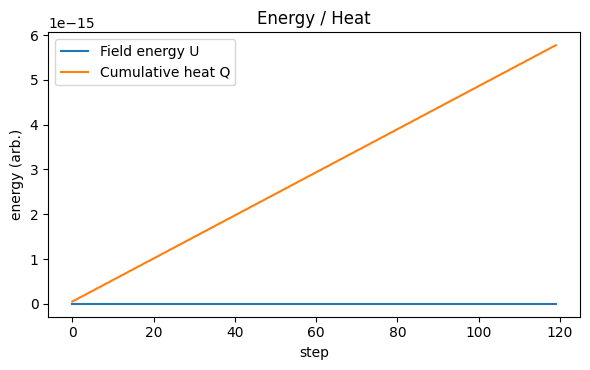

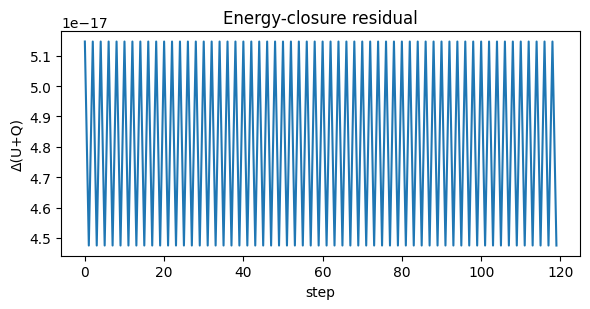

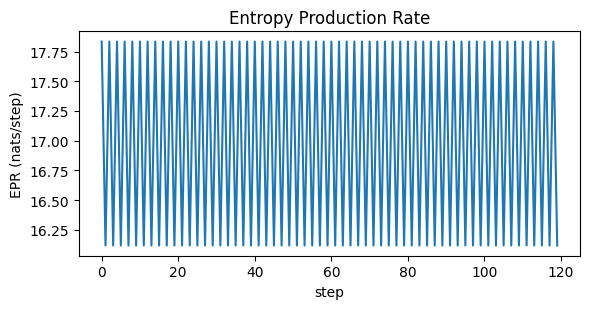

Residual max |Δ(U+Q)| = 5.147e-17 :: PASS
Centroid reliance = 0.625 :: PASS
Illegal edges (post-enforce) = 0 :: PASS
Sink throughput = 0.000 :: FLAG
counts: {'samples': 120, 'energy': 120, 'heat': 120, 'residual': 120, 'phase_error': 0, 'E_mean': 120, 'B_mean': 120}
shapes: B1 (9, 30) B2 (30, 20) Star1 (30,) Star2 (20,)
USE_STAR: True |E|= 30 |F|= 20


In [10]:

# @title 10. **Visualisations — Energy, Heat, Residuals, EPR, Phase** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Plots the main diagnostics:
# @markdown   • Cumulative heat `Q(t)` and field energy `U_field(t)`
# @markdown   • Energy-closure residual `Δ(U+Q)` (should hover near 0)
# @markdown   • EPR over sampled steps (if computable)
# @markdown   • Phase error (if provided in `hist`)
# @markdown - Prints a simple PASS/FLAG summary based on tolerances and structural gates.

import numpy as np
import matplotlib.pyplot as plt

def plot_diagnostics(hist, diag, tol_resid=1e-6):
    s = np.asarray(hist.get("samples", []), dtype=int)
    Q = np.asarray(hist.get("heat", []), dtype=float)
    U = np.asarray(hist.get("energy", []), dtype=float)
    R = np.asarray(hist.get("residual", []), dtype=float)

    plt.figure(figsize=(6.0, 3.8))
    if U.size:
        plt.plot(s, U, label="Field energy U")
    if Q.size:
        plt.plot(s, Q, label="Cumulative heat Q")
    plt.xlabel("step")
    plt.ylabel("energy (arb.)")
    plt.title("Energy / Heat")
    plt.legend()
    plt.tight_layout()
    plt.show()

    if R.size:
        plt.figure(figsize=(6.0, 3.2))
        plt.plot(s, R)
        plt.xlabel("step")
        plt.ylabel("Δ(U+Q)")
        plt.title("Energy-closure residual")
        plt.tight_layout()
        plt.show()

    epr_s = diag.get("EPR_series", {})
    epr_vals = np.asarray(epr_s.get("epr", []), dtype=float)
    epr_samps = np.asarray(epr_s.get("samples", []), dtype=int)
    if epr_vals.size:
        plt.figure(figsize=(6.0, 3.2))
        plt.plot(epr_samps, epr_vals)
        plt.xlabel("step")
        plt.ylabel("EPR (nats/step)")
        plt.title("Entropy Production Rate")
        plt.tight_layout()
        plt.show()

    if "phase_error" in hist:
        pe = np.asarray(hist["phase_error"], dtype=float)
        if pe.size:
            steps = hist.get("phase_error_step", [])
            if isinstance(steps, (list, tuple)) and len(steps) == len(pe):
                ps = np.asarray(steps, dtype=int)
            else:
                ps = np.arange(len(pe))
            plt.figure(figsize=(6.0, 3.2))
            plt.plot(ps, pe)
            plt.xlabel("step")
            plt.ylabel("phase error (deg)")
            plt.title("Phase error")
            plt.tight_layout()
            plt.show()

    resid_max = float(np.nanmax(np.abs(R))) if R.size else np.nan
    resid_pass = (not np.isfinite(resid_max)) or (resid_max <= tol_resid)
    print(f"Residual max |Δ(U+Q)| = {resid_max:.3e} :: {'PASS' if resid_pass else 'FLAG'}")

def gate_report(diag):
    centroid = diag.get('centroid_reliance', np.nan)
    illegal = diag.get('illegal_edges', np.nan)
    sink_tp = diag.get('sink_throughput', np.nan)
    print(f"Centroid reliance = {centroid:.3f} :: {'PASS' if centroid >= 0.6 else 'FLAG'}")
    print(f"Illegal edges (post-enforce) = {illegal} :: {'PASS' if illegal == 0 else 'FLAG'}")
    if np.isfinite(sink_tp):
        print(f"Sink throughput = {sink_tp:.3f} :: {'PASS' if sink_tp > 0 else 'FLAG'}")
    return centroid, illegal, sink_tp

# 0) Safety: inline plots (harmless if already set)
%matplotlib inline

# 1) Rebuild G (Geometry), Breath, DEC, Coupling — then:
hist = run_lenr_core(
    G0,
    steps=120,
    dt=None,
    coherence_gain=0.1,
    report_every=1,
    edge_rates=EDGE_RATES,
    edge_kinds=EDGE_KINDS,
    state=QUAT_STATE,
)
print("counts:", {k: len(hist.get(k, [])) for k in ["samples", "energy", "heat", "residual"]})

# 2) Build diagnostics + plot (robust plotter handles missing x)
diag = diagnostics(G0, hist, roles=G0.graph.get('roles', {}), policy=G0.graph.get('policy', {}), edge_rates=EDGE_RATES, edge_kinds=EDGE_KINDS)
plot_diagnostics(hist, diag)
gate_report(diag)

bd = detect_bursts_from_Q(hist.get("samples", []), hist.get("heat", []), jitter_frac=0.15)
print(f"Bursts: {bd['n']} | unit ≈ {bd['unit']:.3e} | idx: {bd['idx'][:10]}")
phase_samples = len(hist.get("phase_error", []))
print(f"Phase samples: {phase_samples}")
rc_in_vals = np.asarray(hist.get("Rc_in", []), dtype=float)
rc_out_vals = np.asarray(hist.get("Rc_out", []), dtype=float)
rc_in_mean = float(np.nanmean(rc_in_vals)) if rc_in_vals.size else float('nan')
rc_out_mean = float(np.nanmean(rc_out_vals)) if rc_out_vals.size else float('nan')
print(f"R_C mean (in,out): {rc_in_mean:.3f} {rc_out_mean:.3f}")
sink_vals = np.asarray(hist.get("sink_rate", []), dtype=float)
sink_throughput = float(np.nanmean(sink_vals)) if sink_vals.size else float('nan')
print(f"Sink throughput (mean rate): {sink_throughput:.3f}")

print("counts:", {k: len(hist.get(k, [])) for k in ["samples", "energy", "heat", "residual", "phase_error", "phase_error_step", "sink_rate", "Rc_in", "Rc_out", "E_mean", "B_mean"]})
print("shapes:", "B1", B1.shape, "B2", B2.shape, "Star1", np.diag(Star1).shape, "Star2", np.diag(Star2).shape)
print("USE_STAR:", USE_STAR, "|E|=", len(edge_id), "|F|=", len(face_id))
